## GENTRL: Generative Tensorial Reinforcement Learning

Supporting Information for the paper "Deep learning enables rapid identification of potent DDR1 kinase inhibitors".

The GENTRL model is a variational autoencoder with a rich prior distribution of the latent space. We used tensor decompositions to encode the relations between molecular structures and their properties and to learn on data with missing values. We train the model in two steps. First, we learn a mapping of a chemical space on the latent manifold by maximizing the evidence lower bound. We then freeze all the parameters except for the learnable prior and explore the chemical space to find molecules with a high reward.

Link to paper: https://www.nature.com/articles/s41587-019-0224-x.pdf

Credit: https://github.com/insilicomedicine/GENTRL

In [1]:
# Clone the GENTRL repos and cd into directory
!git clone https://github.com/insilicomedicine/GENTRL.git
%cd GENTRL

Cloning into 'GENTRL'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25
Unpacking objects: 100% (25/25), done.
/content/GENTRL


In [ ]:
# Install RDKit
!pip install rdkit-pypi==2021.3.1.5

In [ ]:
# Install the GENTRL model
!python setup.py install

In [ ]:
# Clone the MOSES repo and cd into directory
!git clone https://github.com/molecularsets/moses.git
%cd moses

In [ ]:
# Install MOSES 
!python setup.py install

In [ ]:
# Install dependencies for LatentGAN
!bash install_latentgan_dependencies.sh
%cd ..

In [ ]:
# Install fcd_torch
!git clone https://github.com/insilicomedicine/fcd_torch.git
%cd fcd_torch
!python setup.py install
%cd ..

### Run the pretrain process to train an autoencoder

In [19]:
# Note: change file paths to import these libraries
import gentrl
import torch
import pandas as pd
torch.cuda.set_device(0)

In [20]:
from moses.moses.metrics import mol_passes_filters, QED, SA, logP
from moses.moses.metrics.utils import get_n_rings, get_mol

def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])

def penalized_logP(mol_or_smiles, masked=False, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    reward = logP(mol) - SA(mol) - get_num_rings_6(mol)
    if masked and not mol_passes_filters(mol):
        return default
    return reward

In [21]:
!wget https://media.githubusercontent.com/media/molecularsets/moses/master/data/dataset_v1.csv

--2021-05-24 14:20:01--  https://media.githubusercontent.com/media/molecularsets/moses/master/data/dataset_v1.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84482588 (81M) [text/plain]
Saving to: ‘dataset_v1.csv’

dataset_v1.csv      100%[===================>]  80.57M   210MB/s    in 0.4s    

2021-05-24 14:20:03 (210 MB/s) - ‘dataset_v1.csv’ saved [84482588/84482588]



In [22]:
df = pd.read_csv('dataset_v1.csv')
df = df[df['SPLIT'] == 'train']
df['plogP'] = df['SMILES'].apply(penalized_logP)
df.to_csv('train_plogp_plogpm.csv', index=None)

In [23]:
enc = gentrl.RNNEncoder(latent_size=50)
dec = gentrl.DilConvDecoder(latent_input_size=50)

model = gentrl.GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
model.cuda();

In [24]:
md = gentrl.MolecularDataset(sources=[
    {'path':'train_plogp_plogpm.csv',
     'smiles': 'SMILES',
     'prob': 1,
     'plogP' : 'plogP',
    }], 
    props=['plogP'])

from torch.utils.data import DataLoader
train_loader = DataLoader(md, batch_size=50, shuffle=True, num_workers=1, drop_last=True)

In [ ]:
model.train_as_vaelp(train_loader, lr=1e-4)

In [26]:
!mkdir -p saved_gentrl

In [27]:
model.save('./saved_gentrl/')

### Run the training process to optimize a reward function

In [28]:
import gentrl
import torch
torch.cuda.set_device(0)

In [29]:
enc = gentrl.RNNEncoder(latent_size=50)
dec = gentrl.DilConvDecoder(latent_input_size=50)

model = gentrl.GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
model.cuda();

In [30]:
model.load('saved_gentrl/')
model.cuda();

In [31]:
from moses.moses.metrics import mol_passes_filters, QED, SA, logP
from moses.moses.metrics.utils import get_n_rings, get_mol

from moses.moses.utils import disable_rdkit_log
disable_rdkit_log()

def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])

def penalized_logP(mol_or_smiles, masked=False, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    reward = logP(mol) - SA(mol) - get_num_rings_6(mol)
    if masked and not mol_passes_filters(mol):
        return default
    return reward

In [ ]:
model.train_as_rl(penalized_logP)

In [33]:
!mkdir -p saved_gentrl_after_rl

In [34]:
model.save('./saved_gentrl_after_rl/')

### Sample from the generated data after training

In [35]:
import torch
from rdkit.Chem import Draw

from moses.moses.metrics import mol_passes_filters, QED, SA, logP
from moses.moses.metrics.utils import get_n_rings, get_mol

torch.cuda.set_device(0)

In [36]:
enc = gentrl.RNNEncoder(latent_size=50)
dec = gentrl.DilConvDecoder(latent_input_size=50)

model = gentrl.GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
model.cuda();

In [37]:
model.load('saved_gentrl_after_rl/')
model.cuda();

In [38]:
def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])

def penalized_logP(mol_or_smiles, masked=True, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    reward = logP(mol) - SA(mol) - get_num_rings_6(mol)
    if masked and not mol_passes_filters(mol):
        return default
    return reward

In [39]:
generated = []

while len(generated) < 1000:
    sampled = model.sample(100)
    sampled_valid = [s for s in sampled if get_mol(s)]
    
    generated += sampled_valid

/content/GENTRL/gentrl/lp.py:108: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  x[missed] = 0


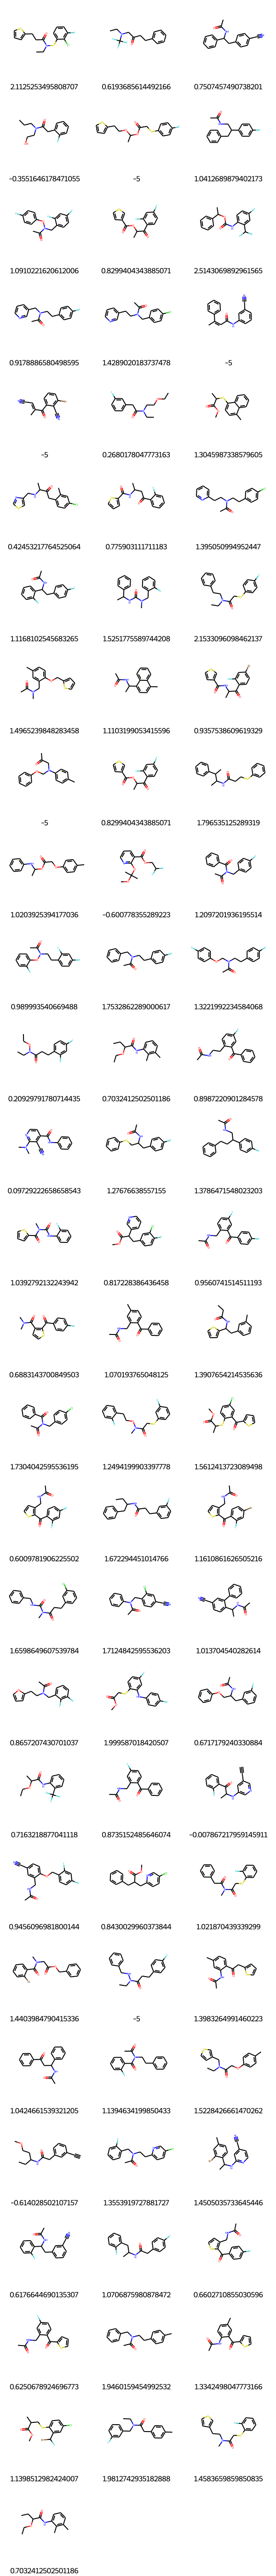

In [40]:
Draw.MolsToGridImage([get_mol(s) for s in sampled_valid], 
                     legends=[str(penalized_logP(s)) for s in sampled_valid])